<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#99ffcc;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Corona Virus Tweets Sentiment Prediction 😷 🦠</h1></center>    

</div>

<p align="center">
  <img width="600" height="300" src="https://spectrum.ieee.org/media-library/photograph-of-someone-holding-a-photo-with-twitter-on-it-and-the-words-covid-19-in-the-background.jpg?id=25591747&width=1200&height=721">
</p>

## **Problem Statement**

<p align="center">
  <img width="600" height="300" src="https://habrastorage.org/webt/t6/sr/jr/t6srjrmjjmm6qn8gpld9emy4txu.gif">
</p>

We Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

**Columns:**

1. Location
2. Tweet At
3. Original Tweet
4. Label

## **Import Libraries and Data**

In [1]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2022-06-26 14:14:59--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py’

explacy.py          100%[===================>]   6.73K  --.-KB/s    in 0.001s  

2022-06-26 14:14:59 (7.87 MB/s) - ‘explacy.py’ saved [6896/6896]



In [2]:
! pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=83add1ed8950dd1a1a2d89e437712a0d90f86b6f8638b2c7538bfc04245796cf
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [84]:
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

# handle table-like data and matrices
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
import emoji

# natural language processing
import nltk
from nltk.corpus import stopwords
import string
import spacy
from spacy import displacy
import explacy
from wordcloud import WordCloud

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# model
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

# to display the total number of rows and columns present in the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download datatattle/covid-19-nlp-text-classification
! unzip /content/covid-19-nlp-text-classification.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 238MB/s]
Archive:  /content/covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [6]:
data_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
data_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

## **Handling Missing Values**

In [7]:
data_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
data_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [9]:
null = data_train.isnull().sum().sort_values(ascending=False)
total = data_train.shape[0]
percent_missing = (data_train.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { 'index': ' column name'})
 
print ('Missing Values in Each Column:\n', missing_data)

Missing Values in Each Column:
      column name  Total missing  Percent missing
0       Location           8590         0.208713
1       UserName              0         0.000000
2     ScreenName              0         0.000000
3        TweetAt              0         0.000000
4  OriginalTweet              0         0.000000
5      Sentiment              0         0.000000


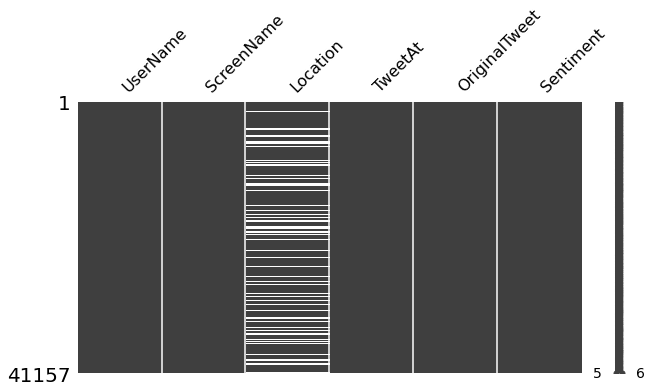

In [10]:
msno.matrix(data_train, figsize=(10, 5));

There are missing values in the location variable. Since we don't use the location for prediction, it doesn't matter.

let's find if we have duplicate rows.

In [11]:
data_train.duplicated().sum()

0

In [12]:
data_test.duplicated().sum()

0

## **Data Analysis and Visualization**

In [13]:
data_train.head(5)

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [14]:
data_train.shape, data_test.shape

((41157, 6), (3798, 6))

In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [16]:
data_train.describe(include=object).T

count unique  \
Location       32567  12220   
TweetAt        41157     30   
OriginalTweet  41157  41157   
Sentiment      41157      5   

                                                             top   freq  
Location                                                  London    540  
TweetAt                                               20-03-2020   3448  
OriginalTweet  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...      1  
Sentiment                                               Positive  11422

In [17]:
print('Unique Sentiments in Train Data:', data_train.Sentiment.unique(), '\n')

print(data_train.Sentiment.value_counts())

Unique Sentiments in Train Data: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive'] 

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


In [18]:
print('Unique Sentiments in Test Data:', data_test.Sentiment.unique(), '\n')

print(data_test.Sentiment.value_counts())

Unique Sentiments in Test Data: ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral'] 

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64


In [19]:
data_train['Sentiment'] = data_train['Sentiment'].map({'Extremely Positive':'Positive','Extremely Negative':'Negative','Neutral':'Neutral','Positive':'Positive','Negative':'Negative'})
data_test['Sentiment'] = data_test['Sentiment'].map({'Extremely Positive':'Positive','Extremely Negative':'Negative','Neutral': 'Neutral','Positive':'Positive','Negative':'Negative'})

In [20]:
print('Unique Sentiments in Train Data:', data_train.Sentiment.unique(), '\n')

class_d = data_train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_d.style.background_gradient(cmap='Blues')

Unique Sentiments in Train Data: ['Neutral' 'Positive' 'Negative'] 



In [21]:
print('Unique Sentiments in Test Data:', data_test.Sentiment.unique(), '\n')

class_d = data_test.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_d.style.background_gradient(cmap='Blues')

Unique Sentiments in Test Data: ['Negative' 'Positive' 'Neutral'] 



In [22]:
data_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [23]:
data_test['Sentiment'].value_counts()

Negative    1633
Positive    1546
Neutral      619
Name: Sentiment, dtype: int64

In [24]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=['Positive', 'Negative', 'Neutral'], values=data_train['Sentiment'].value_counts(), name='Train Sentiment', 
                     marker_colors=['gold', 'mediumturquoise', '#EC7063']), 1, 1)
fig.add_trace(go.Pie(labels=['Positive', 'Negative', 'Neutral'], values=[data_test['Sentiment'].value_counts()[1], data_test['Sentiment'].value_counts()[0], data_test['Sentiment'].value_counts()[2]], name='Test Sentiment', 
                     marker_colors=['gold', 'mediumturquoise', '#EC7063']), 1, 2)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Sentiment Distribution in Train and Test Data<b>', 
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiment Train', x=0.135, y=0.5, font_size=20, showarrow=False),
                 dict(text='Sentiment Test', x=0.86, y=0.5, font_size=20, showarrow=False)])
iplot(fig)

* There is uneven distribution of classes with positive taking the largest of pie followed by negative.


In [25]:
tweets_per_country = data_train['Location'].value_counts().loc[lambda x : x > 102].reset_index(name='counts')

fig = px.bar(x=tweets_per_country['index'], y=tweets_per_country['counts'], color_continuous_scale=px.colors.sequential.Teal_r,
             title='<b>Tweets Count by Country<b>', text_auto=True, color=tweets_per_country['counts'])

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Country'}})
iplot(fig)

In [26]:
tweet_len_pos = data_train[data_train['Sentiment']=='Positive']['OriginalTweet'].str.len()
tweet_len_neg = data_train[data_train['Sentiment']=='Negative']['OriginalTweet'].str.len()
tweet_len_neu = data_train[data_train['Sentiment']=='Neutral']['OriginalTweet'].str.len()

In [27]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Histogram(x = tweet_len_pos, name='Positive', marker_color='#EB89B5') , 1, 1)
fig.add_trace(go.Histogram(x = tweet_len_neg, name='Negative', marker_color='#E9F00B') , 1, 2)
fig.add_trace(go.Histogram(x = tweet_len_neu, name='Neutral', marker_color='#5DADE2') , 1, 3)

fig.update_layout(title_text='<b>Characters in Tweets<b>')
iplot(fig)

In [28]:
tweet_words_pos = data_train[data_train['Sentiment']=='Positive']['OriginalTweet'].str.split().map(lambda x: len(x))
tweet_words_neg = data_train[data_train['Sentiment']=='Negative']['OriginalTweet'].str.split().map(lambda x: len(x))
tweet_words_neu = data_train[data_train['Sentiment']=='Neutral']['OriginalTweet'].str.split().map(lambda x: len(x))

In [29]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Histogram(x = tweet_words_pos, name='Positive', marker_color='#00CC96') , 1, 1)
fig.add_trace(go.Histogram(x = tweet_words_neg, name='Negative', marker_color='#FFA15A') , 1, 2)
fig.add_trace(go.Histogram(x = tweet_words_neu, name='Neutral', marker_color='#E5527A') , 1, 3)

fig.update_layout(title_text='<b>Number of words in Tweets<b>')
iplot(fig)

In [30]:
tweet_words_pos = data_train[data_train['Sentiment']=='Positive']['OriginalTweet'].str.split().map(lambda x: len(x))
tweet_avgwords_pos = tweet_words_pos.map(lambda x: np.mean(x))
tweet_words_neg = data_train[data_train['Sentiment']=='Negative']['OriginalTweet'].str.split().map(lambda x: len(x))
tweet_avgwords_neg = tweet_words_neg.map(lambda x: np.mean(x))
tweet_words_neu = data_train[data_train['Sentiment']=='Neutral']['OriginalTweet'].str.split().map(lambda x: len(x))
tweet_avgwords_neu = tweet_words_neu.map(lambda x: np.mean(x))

In [31]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Histogram(x = tweet_avgwords_pos, name='Positive', marker_color='purple') , 1, 1)
fig.add_trace(go.Histogram(x = tweet_avgwords_neg, name='Negative', marker_color='gold') , 1, 2)
fig.add_trace(go.Histogram(x = tweet_avgwords_neu, name='Neutral', marker_color='#C82735') , 1, 3)

fig.update_layout(title_text='<b>Average Word Length in Tweets<b>')
iplot(fig)

In [32]:
stop = set(stopwords.words('english'))
np.array(stop)

array({'wasn', 'those', 'about', 'until', 'these', 'at', 'our', 'having', 'haven', 'is', 'do', 'out', 'where', 'too', 'were', "wouldn't", 'into', 'after', 'doesn', "don't", 'very', 'shouldn', "isn't", "won't", 'myself', 'or', 'needn', 'that', 'once', 'mustn', 'y', 'been', 'your', "mustn't", "needn't", 'before', 'off', 'further', 'an', 'most', "hadn't", "wasn't", 'any', 'won', 'ours', 'but', 'shan', 'have', "should've", 'm', "that'll", 'so', "aren't", 'from', 'under', 'll', "shan't", 'above', 'weren', 'are', 'here', 'her', 'than', 'other', 'himself', 'below', 'isn', "you're", 'ma', 'yourself', 'couldn', 'd', 'they', "shouldn't", 'again', 'on', 'am', 'both', "doesn't", 'through', 'its', 'did', 'being', 'has', 'them', 'there', "didn't", 'of', "mightn't", 'between', 'all', 'we', 'to', 'herself', 's', 'was', 're', 'theirs', 'his', 'each', "you've", 'themselves', 'during', 'how', 'only', 'it', 'i', 'and', 'down', 'not', 'because', 'a', 'few', 'don', 'ain', 'should', 'be', 'just', 'same', 'no

In [33]:
def create_corpus(target):
    corpus = [] 
    for x in data_train[data_train['Sentiment']==target]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [34]:
corpus_pos = create_corpus('Positive')

dic_pos = defaultdict(int)
for word in corpus_pos:
    if word in stop:
        dic_pos[word]+=1

top_stop_pos = sorted(dic_pos.items(), key=lambda x:x[1], reverse=True)[:10] 

w_pos = []
n_pos = []
for i in range(len(top_stop_pos)):
  w_pos.append(top_stop_pos[i][0])
  n_pos.append(top_stop_pos[i][1])

In [35]:
fig = px.bar(x=w_pos, y=n_pos, color_continuous_scale=px.colors.sequential.Bluyl,
             title='<b>Most Common Stop Words in Positive Sentences<b>', text_auto=True, color=n_pos)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Stop Words'}})
iplot(fig)

In [36]:
corpus_neg = create_corpus('Negative')

dic_neg = defaultdict(int)
for word in corpus_neg:
    if word in stop:
        dic_neg[word]+=1

top_stop_neg = sorted(dic_neg.items(), key=lambda x:x[1], reverse=True)[:10] 

w_neg = []
n_neg = []
for i in range(len(top_stop_neg)):
  w_neg.append(top_stop_neg[i][0])
  n_neg.append(top_stop_neg[i][1])

In [37]:
fig = px.bar(x=w_neg, y=n_neg, color_continuous_scale=px.colors.sequential.dense,
             title='<b>Most Common Stop Words in Negative Sentences<b>', text_auto=True, color=n_neg)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Stop Words'}})
iplot(fig)

In [38]:
corpus_neu = create_corpus('Neutral')

dic_neu = defaultdict(int)
for word in corpus_neu:
    if word in stop:
        dic_neu[word]+=1

top_stop_neu = sorted(dic_neu.items(), key=lambda x:x[1], reverse=True)[:10] 

w_neu = []
n_neu = []
for i in range(len(top_stop_neu)):
  w_neu.append(top_stop_neu[i][0])
  n_neu.append(top_stop_neu[i][1])

In [39]:
fig = px.bar(x=w_neu, y=n_neu, color_continuous_scale=px.colors.sequential.PuRd,
             title='<b>Most Common Stop Words in Neutral Sentences<b>', text_auto=True, color=n_neu)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Stop Words'}})
iplot(fig)

In [40]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
corpus_pos = create_corpus('Positive')

dic_pos = defaultdict(int)
for word in corpus_pos:
    if word in string.punctuation:
        dic_pos[word]+=1

top_stop_pos = sorted(dic_pos.items(), key=lambda x:x[1], reverse=True)[:10] 

w_pos = []
n_pos = []
for i in range(len(top_stop_pos)):
  w_pos.append(top_stop_pos[i][0])
  n_pos.append(top_stop_pos[i][1])

In [42]:
fig = px.bar(x=w_pos, y=n_pos, color_continuous_scale=px.colors.sequential.Cividis,
             title='<b>Most Common Punctuations in Positive Sentences<b>', text_auto=True, color=n_pos)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Punctuations'}})
iplot(fig)

In [43]:
corpus_neg = create_corpus('Negative')

dic_neg = defaultdict(int)
for word in corpus_neg:
    if word in string.punctuation:
        dic_neg[word]+=1

top_stop_neg = sorted(dic_neg.items(), key=lambda x:x[1], reverse=True)[:10] 

w_neg = []
n_neg = []
for i in range(len(top_stop_neg)):
  w_neg.append(top_stop_neg[i][0])
  n_neg.append(top_stop_neg[i][1])

In [44]:
fig = px.bar(x=w_neg, y=n_neg, color_continuous_scale=px.colors.sequential.Plotly3,
             title='<b>Most Common Punctuations in Negative Sentences<b>', text_auto=True, color=n_neg)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Punctuations'}})
iplot(fig)

In [45]:
corpus_neu = create_corpus('Neutral')

dic_neu = defaultdict(int)
for word in corpus_neu:
    if word in string.punctuation:
        dic_neu[word]+=1

top_stop_neu = sorted(dic_neu.items(), key=lambda x:x[1], reverse=True)[:10] 

w_neu = []
n_neu = []
for i in range(len(top_stop_neu)):
  w_neu.append(top_stop_neu[i][0])
  n_neu.append(top_stop_neu[i][1])

In [46]:
fig = px.bar(x=w_neu, y=n_neu, color_continuous_scale=px.colors.sequential.haline,
             title='<b>Most Common Punctuations in Neutral Sentences<b>', text_auto=True, color=n_neu)

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Punctuations'}})
iplot(fig)

In [47]:
def create_corpus():
    corpus = [] 
    for x in data_train['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [48]:
counter = Counter(create_corpus())
common = counter.most_common()

x=[]
y=[]
for word,count in common[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

In [49]:
fig = px.bar(x=y[::-1], y=x[::-1], color_continuous_scale=px.colors.sequential.Reds,
             title='<b>Most Common Words<b>', text_auto=True, color=y[::-1])

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Words'}, 'xaxis': {'title':'Count'}})
iplot(fig)

In [50]:
hashtag_list = []
for word in create_corpus():
   if word[0] == '#':
     hashtag_list.append(word[1:])

In [51]:
counter_hash = Counter(hashtag_list)
common_hash = counter_hash.most_common()

x=[]
y=[]
for word,count in common_hash[:12]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

In [52]:
fig = px.bar(x=y[::-1], y=x[::-1], color_continuous_scale=px.colors.sequential.Greens,
             title='<b>Most Common Hashtags<b>', text_auto=True, color=y[::-1])

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Hashtags'}, 'xaxis': {'title':'Count'}})
iplot(fig)

In [53]:
mention_list = []
for word in create_corpus():
   if word[0] == '@':
     mention_list.append(word[1:])

In [54]:
counter_mention = Counter(mention_list)
common_mention = counter_mention.most_common()

x=[]
y=[]
for word,count in common_mention[1:13]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

In [55]:
fig = px.bar(x=y[::-1], y=x[::-1], color_continuous_scale=px.colors.sequential.Blues,
             title='<b>Most Common Mentions<b>', text_auto=True, color=y[::-1])

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Mentions'}, 'xaxis': {'title':'Count'}})
iplot(fig)

In [56]:
nlp = spacy.load('en_core_web_sm')

In [57]:
explacy.print_parse_info(nlp, data_train['OriginalTweet'][8])

Dep tree          Token                   Dep type Lemma                   Part of Sp
───────────────── ─────────────────────── ──────── ─────────────────────── ──────────
       ┌────►┌┬── Due                     prep     due                     ADP       
       │     │└─► to                      pcomp    to                      PART      
       │     └──► COVID-19                pobj     covid-19                VERB      
       │     ┌──► our                     poss     our                     PRON      
       │     │┌─► retail                  amod     retail                  ADJ       
       │┌─►┌─┼┼── store                   nsubj    store                   NOUN      
       ││  │ │└─► and                     cc       and                     CCONJ     
       ││  │ └──► classroom               conj     classroom               NOUN      
       ││  └─►┌── in                      prep     in                      ADP       
       ││     └─► Atlanta                 pobj     Atl

In [58]:
doc = nlp(data_train['OriginalTweet'][8])

# Count the frequencies of different coarse-grained POS tags:
POS_counts = doc.count_by(spacy.attrs.POS)

for k,v in sorted(POS_counts.items()):
    print(f'{k}. {doc.vocab[k].text:{5}}: {v}')

84. ADJ  : 4
85. ADP  : 7
86. ADV  : 1
87. AUX  : 3
89. CCONJ: 3
90. DET  : 1
92. NOUN : 9
93. NUM  : 2
94. PART : 3
95. PRON : 4
96. PROPN: 4
97. PUNCT: 6
100. VERB : 5
103. SPACE: 1


In [59]:
# Render the dependency parse
displacy.render(doc, style='dep', jupyter=True, options={'distance': 100, 'color': 'black', 'bg': '#e6ffff'})

In [60]:
colors = {'GPE': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', 'DATE': 'radial-gradient(yellow, green)'}
options = {'ents': ['GPE', 'DATE'], 'colors':colors}
for sent in doc.sents:
    displacy.render(nlp(sent.text), style='ent', jupyter=True, options=options)

## **Preprocessing**

Lower Case

In [61]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].agg(lambda x:x.lower())
data_test['OriginalTweet'] = data_test['OriginalTweet'].agg(lambda x:x.lower())

Remove Stopwords

In [62]:
nlp = spacy.load('en_core_web_sm')
stop = set(nlp.Defaults.stop_words)
np.array(set(nlp.Defaults.stop_words))

array({'those', 'about', 'whoever', 'until', 'these', 'others', 'however', 'many', 'eleven', 'is', 'out', 'give', 'were', 'meanwhile', 'therein', 'into', 'after', 'namely', 'part', 'enough', '’re', 'whereupon', 'beside', 'myself', 'or', 'formerly', 'always', 'though', '‘s', 'off', 'elsewhere', 'ca', 'most', 'thereafter', 'last', 'ours', 'but', 'beyond', 'whole', 'somehow', 'so', 'from', 'under', 'unless', "'re", 'here', '‘ve', 'other', 'see', 'below', 'whereafter', 'yourself', 'former', 'never', 'done', 'again', 'front', 'whence', 'am', 'through', 'side', 'did', 'made', 'none', 'must', 'being', 'mostly', 'there', 'afterwards', 'them', 'of', 'neither', '’ve', 'among', 'herself', 'whereby', 'nine', 'hereafter', 're', 'besides', 'his', 'seem', 'herein', 'top', 'used', 'throughout', 'i', 'and', 'not', 'together', 'because', 'a', 'should', 'fifty', 'same', 'mine', 'serious', 'now', 'him', 'which', 'no', 'keep', 'can', 'the', 'some', 'anyhow', 'show', 'why', 'yours', 'by', 'bottom', 'up', 'f

In [63]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Remove Urls and Mentions

In [64]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: re.sub(r"(?:\@|https?\://)\S+", "", x))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: re.sub(r"(?:\@|https?\://)\S+", "", x))

Remove Emoji

In [65]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r"", x))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r"", x))

Remove Hashtags

In [66]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol

data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: ' '.join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', x)))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: ' '.join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', x)))

data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: ' '.join(word.strip() for word in re.split('#|_', x)))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: ' '.join(word.strip() for word in re.split('#|_', x)))

Remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'

In [67]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x))

Remove Punctuations

In [68]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
def remove_punctuations(text):
    for punctuation in string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§':
        text = text.replace(punctuation, '')
    return text

In [70]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(remove_punctuations)
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(remove_punctuations)

Remove Special Characters

In [71]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: x.replace('$', ''))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: x.replace('$', ''))

data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: x.replace('&', ''))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: x.replace('&', ''))

Remove multiple Spaces

In [72]:
data_train['OriginalTweet'] = data_train['OriginalTweet'].apply(lambda x: re.sub("\s\s+" , " ", x))
data_test['OriginalTweet'] = data_test['OriginalTweet'].apply(lambda x: re.sub("\s\s+" , " ", x))

Remove Empty Rows

In [73]:
len(data_train[data_train['OriginalTweet'] == ''])

23

In [74]:
len(data_test[data_test['OriginalTweet'] == ''])

2

In [75]:
data_train.shape, data_test.shape

((41157, 6), (3798, 6))

In [76]:
train = data_train[data_train['OriginalTweet'] != '']
test = data_test[data_test['OriginalTweet'] != '']

In [77]:
train.shape, test.shape

((41134, 6), (3796, 6))

In [78]:
X_train = train['OriginalTweet']
y_train = train['Sentiment']
X_test = test['OriginalTweet']
y_test = test['Sentiment']

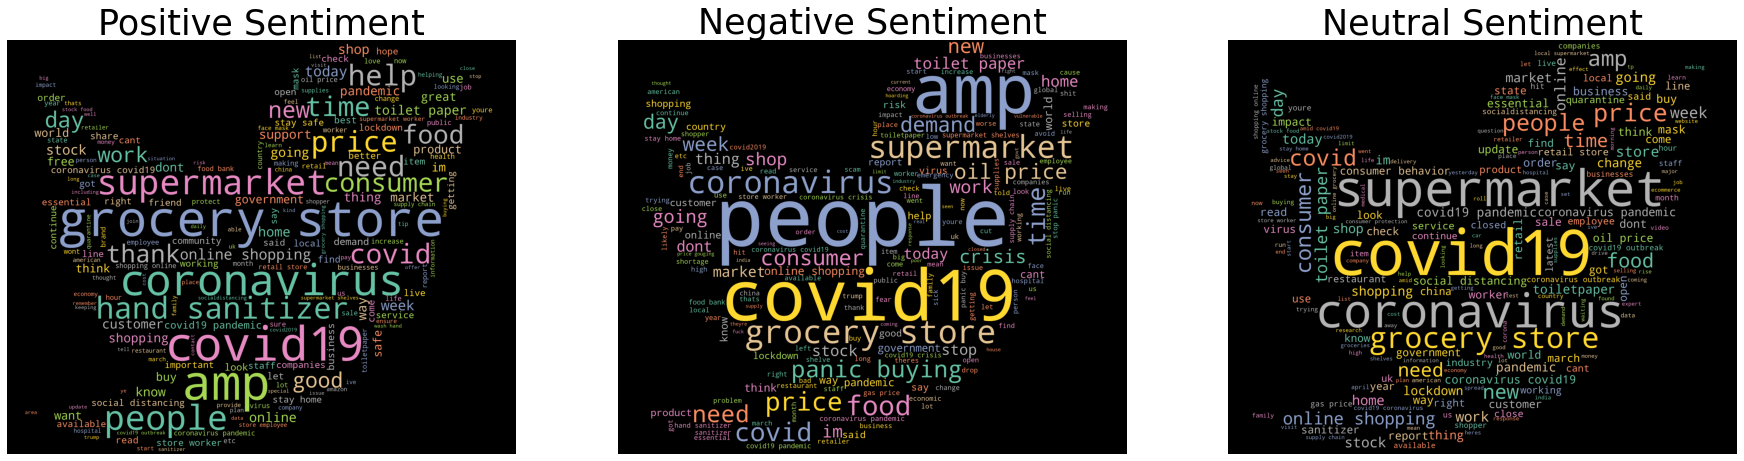

In [85]:
mask = np.array(Image.open('/content/twitter_logo.png'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[31, 16])

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color = 'black',
                colormap = 'Set2', 
                min_font_size = 10,
                mask = mask).generate(' '.join(train[train['Sentiment'] == 'Positive']['OriginalTweet'])) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35)

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color = 'black',
                colormap = 'Set2', 
                min_font_size = 10,
                mask = mask).generate(' '.join(train[train['Sentiment'] == 'Negative']['OriginalTweet'])) 

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35)

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color = 'black',
                colormap = 'Set2', 
                min_font_size = 10,
                mask = mask).generate(' '.join(train[train['Sentiment'] == 'Neutral']['OriginalTweet'])) 

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Sentiment',fontsize=35);  

In [86]:
def create_corpus(target):
    corpus = [] 
    for x in data_train[data_train['Sentiment']==target]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [87]:
counter_p = Counter(create_corpus('Positive'))
common_p = counter_p.most_common()

x_p=[]
y_p=[]
for word,count in common_p[:10]:
  x_p.append(word)
  y_p.append(count)

counter_neg = Counter(create_corpus('Negative'))
common_neg = counter_neg.most_common()

x_neg=[]
y_neg=[]
for word,count in common_neg[:10]:
  x_neg.append(word)
  y_neg.append(count)

counter_neu = Counter(create_corpus('Neutral'))
common_neu = counter_neu.most_common()

x_neu=[]
y_neu=[]
for word,count in common_neu[:10]:
  x_neu.append(word)
  y_neu.append(count)     

In [88]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Bar(x = y_p[::-1], y = x_p[::-1], name='Positive', marker_color='#cc0000', orientation='h', 
                     text=y_p[::-1], textposition='auto') , 1, 1)
fig.add_trace(go.Bar(x = y_neg[::-1], y = x_neg[::-1], name='Negative', marker_color='#80ff00', orientation='h', 
                     text=y_neg[::-1], textposition='auto') , 1, 2)
fig.add_trace(go.Bar(x = y_neu[::-1], y = x_neu[::-1], name='Neutral', marker_color='#00b8e6', orientation='h', 
                     text=y_neu[::-1], textposition='auto') , 1, 3)

fig.update_layout(title_text='<b>Common Words in Tweets After Cleaning<b>')
iplot(fig)

## **Models**

In [ ]:
#HyperParameters
vocab_size = 1000000
max_length = 100
embedding_dim = 64
trunc_type = 'post'
oov_tok = '<OOV>'

#Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

#Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

#Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

y_train = y_train.map({'Negative':0, 'Neutral':1, 'Positive':2})
y_test = y_test.map({'Negative':0, 'Neutral':1, 'Positive':2})

training_padded = np.array(padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

### **Model 1**

In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # or use flatten()
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          200000000 
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 200,006,659
Trainable params: 200,006,659
Non-trainable params: 0
_________________________________________________________________


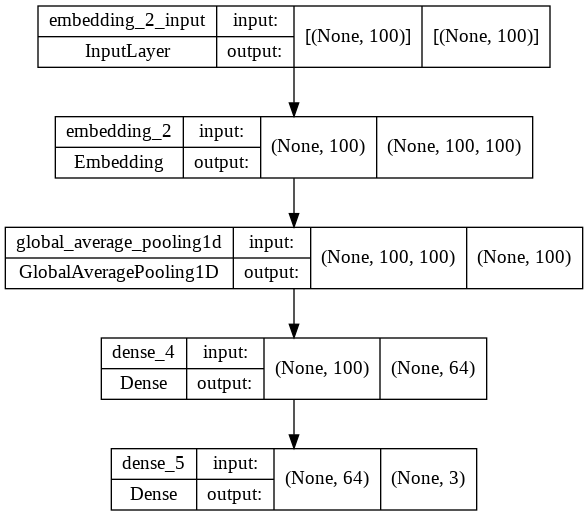

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#filepath = 'my_best_model.epoch{epoch:02d}-loss{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath='DNN_Best_Model', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_freq='epoch')
callbacks = [checkpoint]

In [ ]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, training_labels, epochs = 16, validation_data=(testing_padded, testing_labels), 
                    verbose = 1, callbacks=callbacks)

Epoch 1/16
1285/1286 [============================>.] - ETA: 0s - loss: 1.0526 - accuracy: 0.4386
Epoch 1: val_accuracy improved from -inf to 0.40727, saving model to DNN_Best_Model
INFO:tensorflow:Assets written to: DNN_Best_Model/assets
1286/1286 [==============================] - 57s 40ms/step - loss: 1.0526 - accuracy: 0.4387 - val_loss: 1.0334 - val_accuracy: 0.4073
Epoch 2/16
1286/1286 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.4408
Epoch 2: val_accuracy improved from 0.40727 to 0.41834, saving model to DNN_Best_Model
INFO:tensorflow:Assets written to: DNN_Best_Model/assets
1286/1286 [==============================] - 50s 39ms/step - loss: 1.0347 - accuracy: 0.4408 - val_loss: 1.0155 - val_accuracy: 0.4183
Epoch 3/16
1285/1286 [============================>.] - ETA: 0s - loss: 0.9970 - accuracy: 0.5324
Epoch 3: val_accuracy improved from 0.41834 to 0.59932, saving model to DNN_Best_Model
INFO:tensorflow:Assets written to: DNN_Best_Model/assets
1286/12

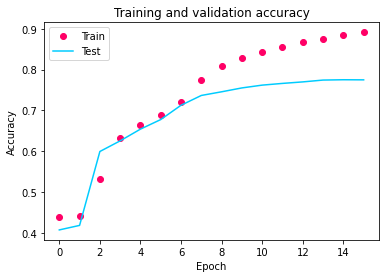

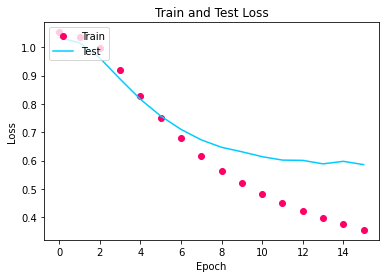

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066')
plt.plot  (epochs, val_acc, color = '#00ccff')
plt.title ('Training and validation accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title ('Train and Test Loss');

In [ ]:
best_DNN_model = tf.keras.models.load_model('DNN_Best_Model')

In [ ]:
best_DNN_model.evaluate(testing_padded, testing_labels, verbose=1)

119/119 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.7750


[0.5976424217224121, 0.7750263214111328]

In [ ]:
predictions = best_DNN_model.predict(testing_padded)
y_pred = np.argmax(predictions, axis = 1)

In [ ]:
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(testing_labels, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.84      0.74      0.79      1633
     Neutral       0.62      0.64      0.63       617
    Positive       0.78      0.86      0.82      1546

    accuracy                           0.78      3796
   macro avg       0.75      0.75      0.75      3796
weighted avg       0.78      0.78      0.77      3796



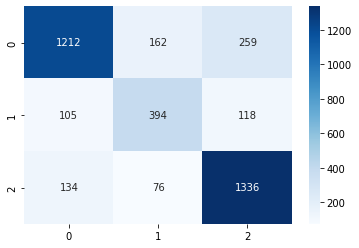

In [ ]:
cm = confusion_matrix(testing_labels, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='');

### **Model 2: LSTM**

In [ ]:
# Hyperparameters
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         200000000 
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3)                

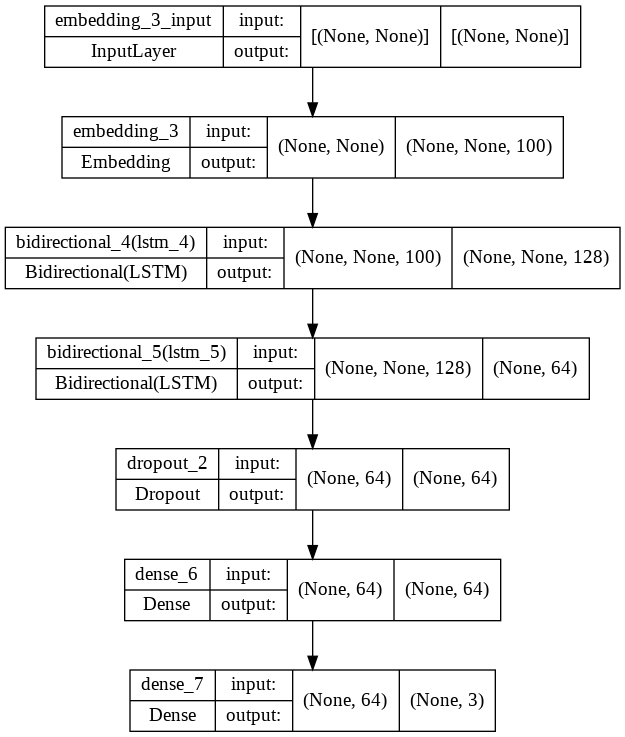

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#filepath = 'my_best_model.epoch{epoch:02d}-loss{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath='LSTM_Best_Model', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_freq='epoch')
callbacks = [checkpoint]

In [ ]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, training_labels, epochs = 5, validation_data=(testing_padded, testing_labels), 
                    verbose = 1, callbacks=callbacks)

Epoch 1/5
1286/1286 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7524
Epoch 1: val_accuracy improved from -inf to 0.83061, saving model to LSTM_Best_Model


INFO:tensorflow:Assets written to: LSTM_Best_Model/assets


INFO:tensorflow:Assets written to: LSTM_Best_Model/assets


1286/1286 [==============================] - 104s 77ms/step - loss: 0.6065 - accuracy: 0.7524 - val_loss: 0.4667 - val_accuracy: 0.8306
Epoch 2/5
1286/1286 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8973
Epoch 2: val_accuracy improved from 0.83061 to 0.83483, saving model to LSTM_Best_Model


INFO:tensorflow:Assets written to: LSTM_Best_Model/assets


INFO:tensorflow:Assets written to: LSTM_Best_Model/assets


1286/1286 [==============================] - 96s 75ms/step - loss: 0.3170 - accuracy: 0.8973 - val_loss: 0.4928 - val_accuracy: 0.8348
Epoch 3/5
1286/1286 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9328
Epoch 3: val_accuracy did not improve from 0.83483
1286/1286 [==============================] - 67s 52ms/step - loss: 0.2153 - accuracy: 0.9328 - val_loss: 0.5586 - val_accuracy: 0.8222
Epoch 4/5
1286/1286 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9526
Epoch 4: val_accuracy did not improve from 0.83483
1286/1286 [==============================] - 67s 52ms/step - loss: 0.1489 - accuracy: 0.9526 - val_loss: 0.6227 - val_accuracy: 0.8145
Epoch 5/5
1285/1286 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.9660
Epoch 5: val_accuracy did not improve from 0.83483
1286/1286 [==============================] - 67s 52ms/step - loss: 0.1065 - accuracy: 0.9660 - val_loss: 0.7465 - val_accuracy: 0.8048


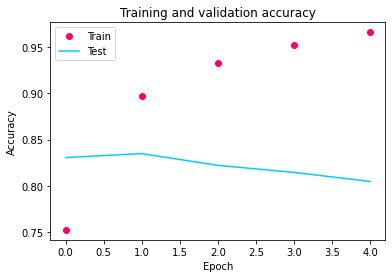

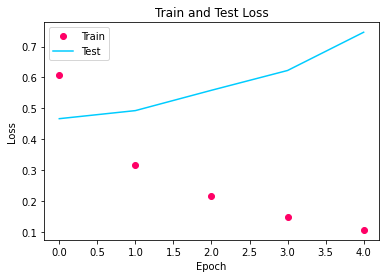

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066')
plt.plot  (epochs, val_acc, color = '#00ccff')
plt.title ('Training and validation accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title ('Train and Test Loss');

In [ ]:
best_LSTM_model = tf.keras.models.load_model('LSTM_Best_Model')

In [ ]:
best_LSTM_model.evaluate(testing_padded, testing_labels, verbose=1)

119/119 [==============================] - 3s 10ms/step - loss: 0.4928 - accuracy: 0.8348


[0.4927993714809418, 0.8348261117935181]

In [ ]:
predictions2 = best_LSTM_model.predict(testing_padded)
y_pred2 = np.argmax(predictions2, axis = 1)

In [ ]:
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(testing_labels, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      1633
     Neutral       0.79      0.75      0.77       617
    Positive       0.84      0.88      0.86      1546

    accuracy                           0.83      3796
   macro avg       0.82      0.82      0.82      3796
weighted avg       0.83      0.83      0.83      3796



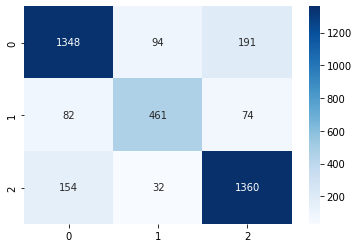

In [ ]:
cm = confusion_matrix(testing_labels, y_pred2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='');